In [ ]:
# TensorBoard Helper Functions and Constants

# Directory to export TensorBoard summary statistics, graph data, etc.
TB_DIR = '/tmp/tensorboard/tf_cnn'

def clean_tb_dir():
    !rm -rf /tmp/tensorboard/tf_cnn

def _start_tb(d):
    """
    Private function that calls `tensorboard` shell command
    
    args:
      d: The desired directory to launch in TensorBoard
    """
    !tensorboard --port=6006 --logdir=$d

def start_tensorboard(d=TB_DIR):
    """
    Starts TensorBoard from the notebook in a separate thread.
    Prevents Jupyter Notebook from halting while TensorBoard runs.
    """
    import threading
    threading.Thread(target=_start_tb, args=(TB_DIR,)).start()
    del threading

def stop_tensorboard():
    """
    Kills all TensorBoard processes
    """
    !ps -aef | grep "tensorboard" | tr -s ' ' | cut -d ' ' -f2 | xargs kill -KILL
    
def reset_tensorboard():
    stop_tensorboard()
    start_tensorboard()

In [2]:
# Import core TensorFlow modules
import tensorflow as tf
import numpy as np

In [3]:
# Modules required for file download and extraction
import os
import sys
import tarfile
from six.moves.urllib.request import urlretrieve
from scipy import ndimage

In [4]:
def maybe_download(filename, url, force=False):
  """Download a file if not present."""
  if force or not os.path.exists('/root/pipeline/datasets/notmnist/' + filename):
    filename, _ = urlretrieve(url + filename, '/root/pipeline/datasets/notmnist/' + filename)
    print('\nDownload complete for {}'.format(filename))
  else:
    print('File {} already present.'.format(filename))
  return '/root/pipeline/datasets/notmnist/' + filename

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('{} already present - don\'t need to extract {}.'.format(root, filename))
  else:
    print('Extracting data for {}. This may take a while. Please wait.'.format(root))
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(root[0:root.rfind('/') + 1])
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print(data_folders)
  return data_folders

In [5]:
# Locations to download data:
url = 'http://yaroslavvb.com/upload/notMNIST/'

In [6]:
# Download two datasets
train_zip_path = maybe_download('notMNIST_small.tar.gz', url)

File notMNIST_small.tar.gz already present.


In [7]:
# Extract datasets
train_folders = maybe_extract(train_zip_path)

/root/pipeline/datasets/notmnist/notMNIST_small already present - don't need to extract /root/pipeline/datasets/notmnist/notMNIST_small.tar.gz.
['/root/pipeline/datasets/notmnist/notMNIST_small/A', '/root/pipeline/datasets/notmnist/notMNIST_small/B', '/root/pipeline/datasets/notmnist/notMNIST_small/C', '/root/pipeline/datasets/notmnist/notMNIST_small/D', '/root/pipeline/datasets/notmnist/notMNIST_small/E', '/root/pipeline/datasets/notmnist/notMNIST_small/F', '/root/pipeline/datasets/notmnist/notMNIST_small/G', '/root/pipeline/datasets/notmnist/notMNIST_small/H', '/root/pipeline/datasets/notmnist/notMNIST_small/I', '/root/pipeline/datasets/notmnist/notMNIST_small/J']


In [8]:
len(train_folders)

10

In [9]:
image_height = 28  # Pixel height of images
image_width = 28  # Pixel width of images
pixel_depth = 255.0  # Number of levels per pixel
expected_img_shape = (image_height, image_width)  # Black and white image, no 3rd dimension
num_labels = len(train_folders)

def load_image_folder(folder):
  """Load the data for a single image label."""
  
  # Create a list of image paths inside the folder  
  image_files = os.listdir(folder)
  # Create empty numpy array to hold data
  dataset = np.ndarray(shape=(len(image_files), image_height, image_width),
                         dtype=np.float32)
  num_images = 0  # Counter for number of successful images loaded
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      # Read in image pixel data as floating point values
      image_data = ndimage.imread(image_file).astype(float)
      # Scale values: [0.0, 255.0] => [-1.0, 1.0] 
      image_data = (image_data - pixel_depth / 2) / (pixel_depth / 2)
      if image_data.shape != expected_img_shape:
        print('File {} has unexpected dimensions: '.format(str(image_data.shape)))
        continue
      # Add image to the numpy array dataset
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- skipping this file and moving on.')
  
  # Trim dataset to remove unused space
  dataset = dataset[0:num_images, :, :]
  return dataset

In [10]:
def make_data_label_arrays(num_rows, image_height, image_width):
  """
  Creates and returns empty numpy arrays for input data and labels
  """
  if num_rows:
    dataset = np.ndarray((num_rows, image_height, image_width), dtype=np.float32)
    labels = np.ndarray(num_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def collect_datasets(data_folders):
  datasets = []
  total_images = 0
  for label, data_folder in enumerate(data_folders):
    # Bring all test folder images in as numpy arrays
    dataset = load_image_folder(data_folder)
    num_images = len(dataset)
    total_images += num_images
    datasets.append((dataset, label, num_images))
  return datasets, total_images

def merge_train_test_datasets(datasets, total_images, percent_test):
    num_train = total_images * (1.0 - percent_test)
    num_test = total_images * percent_test
    train_dataset, train_labels = make_data_label_arrays(num_train, image_height, image_width)
    test_dataset, test_labels = make_data_label_arrays(num_test, image_height, image_width)
    
    train_counter = 0
    test_counter = 0
    dataset_counter = 1
    for dataset, label, num_images in datasets:
      np.random.shuffle(dataset)
      if dataset_counter != len(datasets):
        n_v = num_images // (1.0 / percent_test)
        n_t = num_images - n_v
      else:
        # Last label, make sure dataset sizes match up to what we created
        n_v = len(test_dataset) - test_counter
        n_t = len(train_dataset) - train_counter
      train_dataset[train_counter: train_counter + n_t] = dataset[:n_t]
      train_labels[train_counter: train_counter + n_t] = label
      test_dataset[test_counter: test_counter + n_v] = dataset[n_t: n_t + n_v]
      test_labels[test_counter: test_counter + n_v] = label
      train_counter += n_t
      test_counter += n_v
      dataset_counter += 1
    return train_dataset, train_labels, test_dataset, test_labels

In [11]:
train_test_datasets, train_test_total_images = collect_datasets(train_folders)

('Could not read:', '/root/pipeline/datasets/notmnist/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png', ':', IOError('cannot identify image file',), '- skipping this file and moving on.')
('Could not read:', '/root/pipeline/datasets/notmnist/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png', ':', IOError('cannot identify image file',), '- skipping this file and moving on.')


In [12]:
train_dataset, train_labels, test_dataset, test_labels = \
  merge_train_test_datasets(train_test_datasets, train_test_total_images, 0.1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-int

In [13]:
len(train_dataset)

16851

In [14]:
# Convert data examples into 3-D tensors
num_channels = 1  # grayscale
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_width, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels



In [15]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

In [16]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (16851, 28, 28, 1), (16851, 10))
('Test set', (1872, 28, 28, 1), (1872, 10))


In [17]:
def shuffle_data_with_labels(dataset, labels):
    indices = range(len(dataset))
    np.random.shuffle(indices)
    new_data = np.ndarray(dataset.shape, dataset.dtype)
    new_labels = np.ndarray(labels.shape, dataset.dtype)
    n = 0
    for i in indices:
        new_data[n] = dataset[i]
        new_labels[n] = labels[i]
        n += 1
    return new_data, new_labels

In [18]:
train_dataset, train_labels = shuffle_data_with_labels(train_dataset, train_labels)

In [25]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
  def variable_summaries(var, name):
    with tf.name_scope("summaries"):
      mean = tf.reduce_mean(var)
      tf.scalar_summary('mean/' + name, mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
      tf.scalar_summary('sttdev/' + name, stddev)
      tf.scalar_summary('max/' + name, tf.reduce_max(var))
      tf.scalar_summary('min/' + name, tf.reduce_min(var))
      tf.histogram_summary(name, var)

  # Input data.
  input_data = tf.placeholder(
    tf.float32, shape=(None, image_height, image_width, num_channels), name="input_data")
  input_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name="input_labels")
  keep_rate = tf.placeholder(tf.float32, shape=(), name="keep_rate")
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1), name="L1Weights")
  layer1_biases = tf.Variable(tf.zeros([depth]), name="L1Bias")
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1), name="L2Weights")
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="L2Bias")
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1), name="L3Weights")
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="L3Bias")
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1), name="L4Weights")
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name="L4Bias")
  
  # Add variable summaries
  for v in [layer1_weights, layer2_weights, layer3_weights, layer4_weights,
            layer1_biases, layer2_biases, layer3_biases, layer4_biases]:
    variable_summaries(v, v.name)
  
  # Model.
  def model(data):
    with tf.name_scope("Layer1"):
      conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME', name="2DConvolution")
      hidden = tf.nn.relu(conv + layer1_biases, name="ReLu")
      dropped = tf.nn.dropout(hidden, keep_rate, name="Dropout")
    with tf.name_scope("Layer2"):
      conv = tf.nn.conv2d(dropped, layer2_weights, [1, 2, 2, 1], padding='SAME', name="2DConvolution")
      hidden = tf.nn.relu(conv + layer2_biases, name="ReLu")
      dropped = tf.nn.dropout(hidden, keep_rate, name="Dropout")
    with tf.name_scope("Layer3"):
      shape = dropped.get_shape().as_list()
      reshape = tf.reshape(dropped, [-1, shape[1] * shape[2] * shape[3]])
      hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases, name="ReLu")
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(input_data)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, input_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training and test data.
  model_prediction = tf.nn.softmax(logits, name="prediction")
  label_prediction = tf.argmax(model_prediction, 1, name="predicted_label")
   
  with tf.name_scope('summaries'):
    tf.scalar_summary('loss', loss)
    with tf.name_scope('accuracy'):
      correct_prediction = tf.equal(label_prediction, tf.argmax(input_labels, 1))
      model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
      tf.scalar_summary('accuracy', model_accuracy)
    
  merged_summaries = tf.merge_all_summaries()
  init = tf.initialize_all_variables()

In [26]:
num_steps = 1001

clean_tb_dir()

session = tf.Session(graph=graph)
writer = tf.train.SummaryWriter(TB_DIR, graph=session.graph)
session.run(init)
print('Initialized')
for step in range(num_steps):
  offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
  batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
  batch_labels = train_labels[offset:(offset + batch_size), :]
  feed_dict = {input_data : batch_data, input_labels : batch_labels, keep_rate: 0.5}
  _, l, predictions, accuracy, summaries = session.run(
    [optimizer, loss, model_prediction, model_accuracy, merged_summaries], feed_dict=feed_dict)
  if (step % 50 == 0):
    writer.add_summary(summaries)
    print('Minibatch loss at step %d: %f' % (step, l))
    print('Minibatch accuracy: {}'.format(accuracy))
test_dict = {input_data : test_dataset, input_labels : test_labels, keep_rate: 1.0}
test_accuracy = session.run(model_accuracy, feed_dict=test_dict)
print('Test accuracy: {}'.format(test_accuracy))
writer.close()

Initialized
Minibatch loss at step 0: 4.861333
Minibatch accuracy: 0.171875
Minibatch loss at step 50: 1.438927
Minibatch accuracy: 0.453125
Minibatch loss at step 100: 0.974674
Minibatch accuracy: 0.734375
Minibatch loss at step 150: 0.637842
Minibatch accuracy: 0.828125
Minibatch loss at step 200: 0.887668
Minibatch accuracy: 0.796875
Minibatch loss at step 250: 0.303333
Minibatch accuracy: 0.9375
Minibatch loss at step 300: 0.484798
Minibatch accuracy: 0.859375
Minibatch loss at step 350: 0.604264
Minibatch accuracy: 0.8125
Minibatch loss at step 400: 0.563976
Minibatch accuracy: 0.859375
Minibatch loss at step 450: 0.449784
Minibatch accuracy: 0.90625
Minibatch loss at step 500: 0.713067
Minibatch accuracy: 0.8125
Minibatch loss at step 550: 0.580143
Minibatch accuracy: 0.78125
Minibatch loss at step 600: 0.458130
Minibatch accuracy: 0.875
Minibatch loss at step 650: 0.706458
Minibatch accuracy: 0.8125
Minibatch loss at step 700: 0.477830
Minibatch accuracy: 0.84375
Minibatch loss 

In [ ]:
start_tensorboard()

In [ ]:
stop_tensorboard()

Predicted character: A
Actual label: A


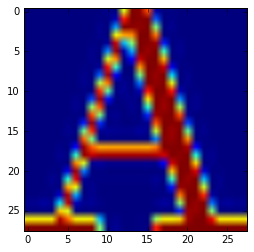

In [38]:
# Visualize data:
import matplotlib.pyplot as plt
%matplotlib inline

i = np.random.randint(len(test_dataset))
data = test_dataset[i,:,:,:]
pixels = data[:, :, 0]
plt.imshow(pixels)

feed_me = np.ndarray((1, image_height, image_width, 1), np.float32)
feed_me[0] = data
feed_dict = {input_data: feed_me, keep_rate: 1.0}
prediction = session.run(label_prediction, feed_dict=feed_dict)
print("Predicted character: " + chr(prediction + ord('A')))
print("Actual label: " + chr(np.argmax(test_labels[i]) + ord('A')))